In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d
import colorsys

In [2]:
# %matplotlib widget 

## Load data

In [3]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [4]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = './training_set/alpha/grid/S_q_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = './training_set/alpha/grid/S_q_{}.5.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(100*len(p_Grid),128)[:,1:]
p_Grid = np.array(p_Grid).reshape(100*len(p_Grid),3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)]))

k_z = p_Grid[:,0]
alpha = p_Grid[:,1]
kappa = p_Grid[:,2]
logkappa = np.log(kappa)
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)

#################################
S_q_Rand = []
p_Rand = []
for i in range(10):
    #### load data ####
    filename = './training_set/alpha/rand/S_q_rand_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Rand.append(S_q_kxy)
    p_Rand.append(k_grid)

S_q_Rand = np.array(S_q_Rand).reshape(100*len(p_Rand),128)[:,1:]
p_Rand = np.array(p_Rand).reshape(100*len(p_Rand),3)
S_q_sm_Rand = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Rand)]))

k_z_Rand = p_Rand[:,0]
alpha_Rand = p_Rand[:,1]
kappa_Rand = p_Rand[:,2]
logkappa_Rand = np.log(kappa_Rand)


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

kappa in
[128.          90.50966799  64.          45.254834    32.
  22.627417    16.          11.3137085    8.           5.65685425
   4.           2.82842712   2.           1.41421356   1.
   0.70710678   0.5          0.35355339   0.25         0.1767767 ]


In [5]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[1])<tol
    id_kappa = np.abs(kappa-parameters[2])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = (parameters[0]-1)/10
    alpha_reduced = parameters[1]/0.5
    kappa_reduced = np.log(128/parameters[2])/10
    return [k_z_reduced, kappa_reduced, alpha_reduced]

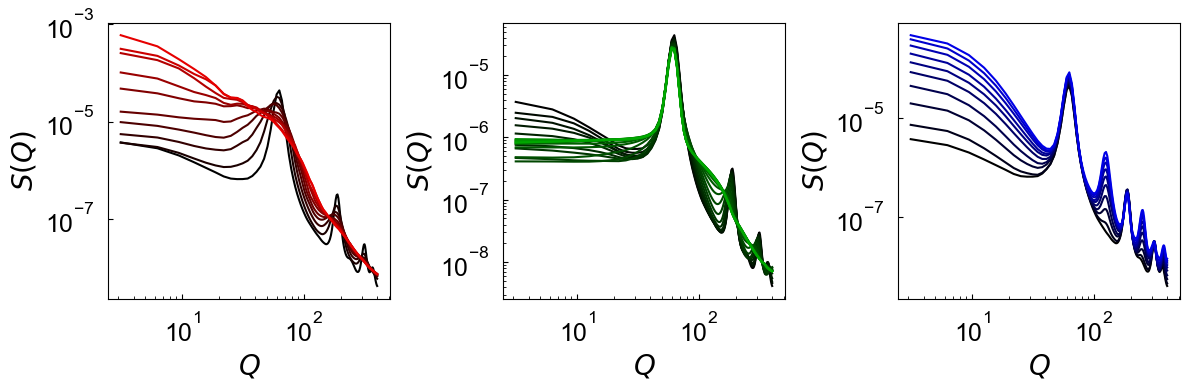

In [6]:
def plot_data_all():
    ## plot results: varying k_z
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1,3,1)

    for i, k_z_i in enumerate(set_k_z):
        parameters = [k_z_i,set_alpha[0],set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$S(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,2)

    for i, kappa_i in enumerate(set_kappa):
        parameters = [set_k_z[0],set_alpha[0],kappa_i]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$S(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,3)

    for i, alpha_i in enumerate(set_alpha):
        parameters = [set_k_z[0],alpha_i,set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$S(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    plt.tight_layout()
    plt.show()

plot_data_all()

## GPR

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [8]:
zscore = lambda X: np.array([(x-np.mean(x))/np.std(x) for x in X])
f_F = lambda x: np.log(x)-0*np.mean(np.log(x),axis=0) # N by 80

### training sets and test sets

In [9]:
def GPR_datasets(training_sets, test_sets):
    F_tr = training_sets[0]
    F_te = test_sets[0]
    p_tr = training_sets[1]
    p_te = test_sets[1]

    # X_tr = F_tr.astype('float32')
    # X_te = F_te.astype('float32')
    X_tr = zscore(F_tr.astype('float32'))
    X_te = zscore(F_te.astype('float32'))

    Y_tr_0 = p_tr[:,0].astype('float32')
    Y_tr_1 = p_tr[:,1].astype('float32')
    Y_tr_2 = p_tr[:,2].astype('float32')
    Y_te_0 = p_te[:,0].astype('float32')
    Y_te_1 = p_te[:,1].astype('float32')
    Y_te_2 = p_te[:,2].astype('float32')

    Y_tr_0_mean = np.mean(Y_tr_0)
    Y_tr_0_std = np.std(Y_tr_0)
    Y_tr_0_z = (Y_tr_0-Y_tr_0_mean)/Y_tr_0_std
    Y_tr_1_mean = np.mean(Y_tr_1)
    Y_tr_1_std = np.std(Y_tr_1)
    Y_tr_1_z = (Y_tr_1-Y_tr_1_mean)/Y_tr_1_std
    Y_tr_2_mean = np.mean(Y_tr_2)
    Y_tr_2_std = np.std(Y_tr_2)
    Y_tr_2_z = (Y_tr_2-Y_tr_2_mean)/Y_tr_2_std

    Y_te_0_z = (Y_te_0-Y_tr_0_mean)/Y_tr_0_std
    Y_te_1_z = (Y_te_1-Y_tr_1_mean)/Y_tr_1_std
    Y_te_2_z = (Y_te_2-Y_tr_2_mean)/Y_tr_2_std

    data_dict = {
                 'X_tr': X_tr, 'X_te': X_te,
                 'Y_tr': np.array([Y_tr_0, Y_tr_1, Y_tr_2]), 'Y_te': np.array([Y_te_0, Y_te_1, Y_te_2]),
                 'Y_tr_mean': np.array([Y_tr_0_mean, Y_tr_1_mean, Y_tr_2_mean]), 
                 'Y_tr_std': np.array([Y_tr_0_std, Y_tr_1_std, Y_tr_2_std]),
                 'Y_tr_z': np.array([Y_tr_0_z, Y_tr_1_z, Y_tr_2_z]),
                 'Y_te_z': np.array([Y_te_0_z, Y_te_1_z, Y_te_2_z]),
                 }

    return data_dict

In [10]:
#select Grid set range
index_kappa_Grid = (p_Grid[:,2]>=2)*(p_Grid[:,2]<=200)

#select Rand set range
index_kappa_Rand = (p_Rand[:,2]>=0)*(p_Rand[:,2]<=200)

F_Grid_sm = (f_F(S_q_sm_Grid))
F_Grid = (f_F(S_q_Grid))
F_Rand_sm = (f_F(S_q_sm_Rand))
F_Rand = (f_F(S_q_Rand))

p_Grid_i = np.array([k_z,logkappa,alpha]).T
p_Rand_i = np.array([k_z_Rand,logkappa_Rand,alpha_Rand]).T

train_on_grid = True
if train_on_grid:
    datasets = GPR_datasets([F_Grid_sm[index_kappa_Grid,:],p_Grid_i[index_kappa_Grid,:]],
                            [F_Rand_sm[index_kappa_Rand,:],p_Rand_i[index_kappa_Rand,:]])
    datasets_all = GPR_datasets([F_Grid_sm,p_Grid_i],
                            [F_Rand_sm,p_Rand_i])
    p_test = p_Rand[index_kappa_Rand]
else:
    datasets = GPR_datasets([F_Rand_sm[index_kappa_Rand,:],p_Rand_i[index_kappa_Rand,:]],
                            [F_Grid_sm[index_kappa_Grid,:],p_Grid_i[index_kappa_Grid,:]])
    datasets_all = GPR_datasets([F_Grid_sm,p_Grid_i],
                            [F_Rand_sm,p_Rand_i])
    p_test = p_Grid[index_kappa_Grid]

### LML landscape

In [11]:
kernel = RBF(1) + WhiteKernel(1)
gp_0 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None).fit(datasets['X_tr'], datasets['Y_tr_z'][0])
gp_1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None).fit(datasets['X_tr'], datasets['Y_tr_z'][1])
gp_2 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None).fit(datasets['X_tr'], datasets['Y_tr_z'][2])

def GP_LML(gp, Lmbda, Sigma):
    LML = [[gp.log_marginal_likelihood(np.log([Lmbda[i, j], Sigma[i, j]]))
        for i in range(Lmbda.shape[0])]
        for j in range(Lmbda.shape[1])]
    LML = np.array(LML).T
    return LML

n_LML_grid = 16
lmbda = np.logspace(-0.5, 1.5, n_LML_grid)
sigma = np.logspace(-5, -1, n_LML_grid)
Lmbda_0, Sigma_0 = np.meshgrid(lmbda, sigma)

LML_0 = GP_LML(gp_0, Lmbda_0, Sigma_0)
index = np.argmax(LML_0)
index_arr_0 = np.unravel_index(index, LML_0.shape)
print('LML_0 done')

lmbda = np.logspace(-0.5, 1.5, n_LML_grid)
sigma = np.logspace(-4, -0, n_LML_grid)
Lmbda_1, Sigma_1 = np.meshgrid(lmbda, sigma)

LML_1 = GP_LML(gp_1, Lmbda_1, Sigma_1)
index = np.argmax(LML_1)
index_arr_1 = np.unravel_index(index, LML_1.shape)
print('LML_1 done')

lmbda = np.logspace(-1.5, 0.5, n_LML_grid)
sigma = np.logspace(-3, 1, n_LML_grid)
# lmbda = np.logspace(0, 2, n_LML_grid)
# sigma = np.logspace(-5, -1, n_LML_grid)
Lmbda_2, Sigma_2 = np.meshgrid(lmbda, sigma)

LML_2 = GP_LML(gp_2, Lmbda_2, Sigma_2)
index = np.argmax(LML_2)
index_arr_2 = np.unravel_index(index, LML_2.shape)
print('LML_2 done')

filename = 'LML_z.mat'
mdic = {'LML_0' : LML_0, 'LML_1' : LML_1, 'LML_2' : LML_2}
savemat(filename, mdic)

LML_0 done
LML_1 done
LML_2 done


### Train GPR model

In [12]:
kernel_0 = RBF(Lmbda_0[index_arr_0]*1, (1e0, 1e2)) + WhiteKernel(Sigma_0[index_arr_0]*1, (5e-4,5e-3))
gp_opt_0 = GaussianProcessRegressor(kernel=kernel_0, n_restarts_optimizer=0, optimizer = None)
gp_opt_0.fit(datasets['X_tr'], datasets['Y_tr_z'][0])
# gp_opt_0.optimizer = None
# gp_opt_0.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][0])

print('LML_0 done')

kernel_1 = RBF(Lmbda_1[index_arr_1]*1, (1e0, 1e1)) + WhiteKernel(Sigma_1[index_arr_1]*1, (1e-3,1e-1))
gp_opt_1 = GaussianProcessRegressor(kernel=kernel_1, n_restarts_optimizer=0, optimizer = None)
gp_opt_1.fit(datasets['X_tr'], datasets['Y_tr_z'][1])
# gp_opt_1.optimizer = None
# gp_opt_1.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][1])

print('LML_1 done')

kernel_2 = RBF(Lmbda_2[index_arr_2]*1, (1e-4, 1e2)) + WhiteKernel(Sigma_2[index_arr_2]*1, (1e-3,1e-2))
gp_opt_2 = GaussianProcessRegressor(kernel=kernel_2, n_restarts_optimizer=0, optimizer = None)
gp_opt_2.fit(datasets['X_tr'], datasets['Y_tr_z'][2])
# gp_opt_2.optimizer = None
# gp_opt_2.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][2])

print('LML_2 done')

LML_0 done
LML_1 done
LML_2 done


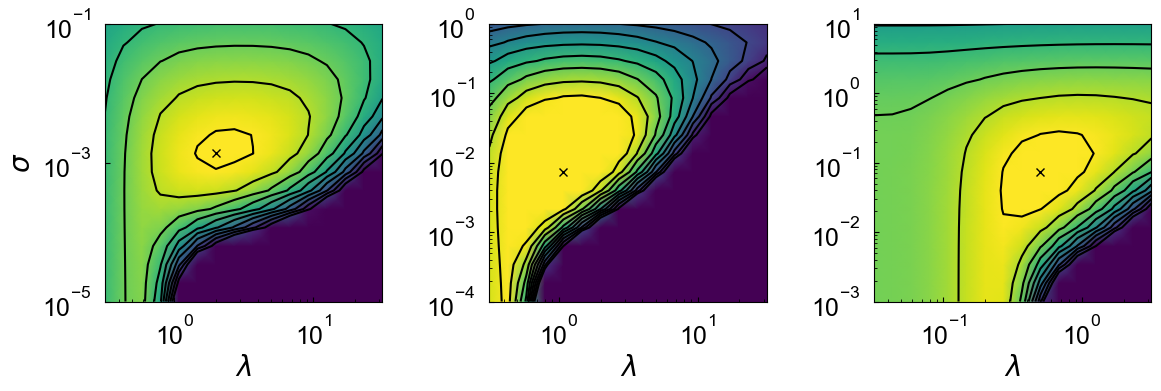

In [14]:
#### plotting
def plot_LML():
        plt.close()
        fig = plt.figure(figsize=(12,4))#,dpi=192)

        ## k_z
        ax = fig.add_subplot(1, 3, 1)
        ax.set_aspect(0.5)

        levels_min = -4e3
        levels_max = 2e3
        levels = np.linspace(levels_min,levels_max,10)

        ax.plot(Lmbda_0[index_arr_0],Sigma_0[index_arr_0], 'xk')
        # ax.plot(gp_opt_0.get_params()['kernel__k1__length_scale'],
        #         gp_opt_0.get_params()['kernel__k2__noise_level'],'sr',fillstyle='none')

        ax.contour(Lmbda_0, Sigma_0, LML_0, levels, colors='k', linestyles='-')
        ax.pcolormesh(Lmbda_0, Sigma_0, LML_0, shading='gouraud', vmin = levels_min, vmax = levels_max)

        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(r'$\lambda$',fontsize=20)
        ax.set_ylabel(r'$\sigma$',fontsize=20)
        ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

        ## alpha
        ax = fig.add_subplot(1, 3, 2)
        ax.set_aspect(0.5)

        levels_min = -2e3
        levels_max = 0
        levels = np.linspace(levels_min,levels_max,10)

        ax.plot(Lmbda_1[index_arr_1],Sigma_1[index_arr_1], 'xk')
        # ax.plot(gp_opt_1.get_params()['kernel__k1__length_scale'],
        #         gp_opt_1.get_params()['kernel__k2__noise_level'],'sr',fillstyle='none')

        ax.contour(Lmbda_1, Sigma_1, LML_1, levels, colors='k', linestyles='-')
        ax.pcolormesh(Lmbda_1, Sigma_1, LML_1, shading='gouraud', vmin = levels_min, vmax = levels_max)

        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(r'$\lambda$',fontsize=20)
        # ax.set_ylabel(r'$\sigma$',fontsize=20)
        ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

        plt.tight_layout()

        ## kappa
        ax = fig.add_subplot(1, 3, 3)
        ax.set_aspect(0.5)

        levels_min = -5e3
        levels_max = -1e3
        levels = np.linspace(levels_min,levels_max,10)

        ax.plot(Lmbda_2[index_arr_2],Sigma_2[index_arr_2], 'xk')
        # ax.plot(gp_opt_2.get_params()['kernel__k1__length_scale'],
        #         gp_opt_2.get_params()['kernel__k2__noise_level'],'sr',fillstyle='none')

        ax.contour(Lmbda_2, Sigma_2, LML_2, levels, colors='k', linestyles='-')
        ax.pcolormesh(Lmbda_2, Sigma_2, LML_2, shading='gouraud', vmin = levels_min, vmax = levels_max)

        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(r'$\lambda$',fontsize=20)
        # ax.set_ylabel(r'$\sigma$',fontsize=20)
        ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

        plt.tight_layout()
plot_LML()

### Prediction

### load test sets

In [15]:
Y_pred_0, Y_std_0 = gp_opt_0.predict(datasets['X_te'],return_std=True)
Y_pred_1, Y_std_1 = gp_opt_1.predict(datasets['X_te'],return_std=True)
Y_pred_2, Y_std_2 = gp_opt_2.predict(datasets['X_te'],return_std=True)

Y_pred_0 = Y_pred_0*datasets['Y_tr_std'][0] + datasets['Y_tr_mean'][0]
Y_pred_1 = Y_pred_1*datasets['Y_tr_std'][1] + datasets['Y_tr_mean'][1]
Y_pred_2 = Y_pred_2*datasets['Y_tr_std'][2] + datasets['Y_tr_mean'][2]
Y_std_0 = Y_std_0*datasets['Y_tr_std'][0]
Y_std_1 = Y_std_1*datasets['Y_tr_std'][1]
Y_std_2 = Y_std_2*datasets['Y_tr_std'][2]

Y_test_0 = datasets['Y_te'][0]
Y_test_1 = datasets['Y_te'][1]
Y_test_2 = datasets['Y_te'][2]

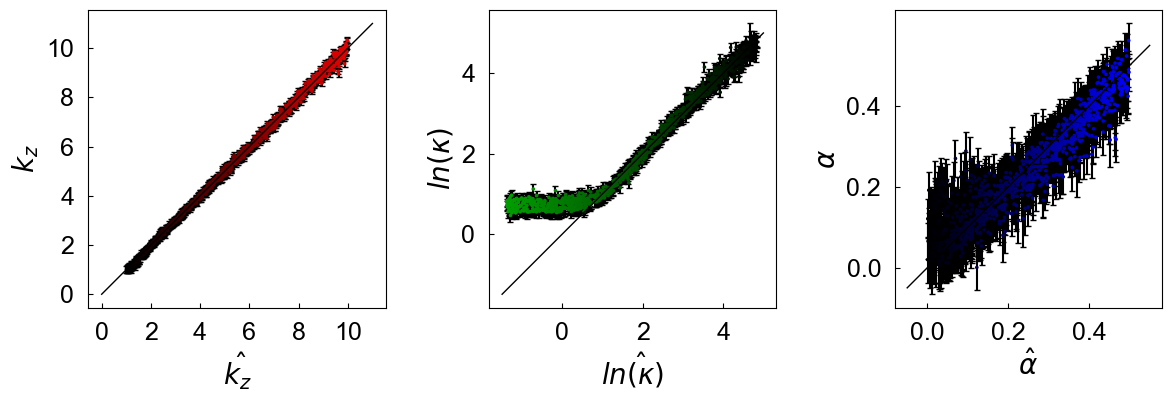

In [16]:
## plot results
from matplotlib.collections import LineCollection
plt.close()
fig = plt.figure(figsize=(12,4))

## k_z
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
colors = [color_params(p) for p in p_test]

ax.scatter(Y_test_0, Y_pred_0, s=10, c=colors*np.array([1,0,0]), marker='.')
ax.errorbar(Y_test_0,Y_pred_0,Y_std_0,capsize=2,color='k',zorder=-2,ls='')
ax.plot([0,11],[0,11],'-k',lw=1)

# for i in range(len(p_test)):
#     color = color_params(p_test[i])

#     ax.plot([0,10],[0,10],'-k',lw=1)
#     # ax.errorbar(Y_test_0[i],Y_pred_0[i],Y_std_0[i],capsize=2,color=color,zorder=2)
#     ax.plot(Y_test_0[i],Y_pred_0[i],'.',color=color,zorder=3,ms=1)
    

ax.set_xlabel(r'$\hat{k_z}$',fontsize=20)
ax.set_ylabel(r'$k_z$',fontsize=20)
ax.set_xticks([0,2,4,6,8,10])
ax.set_yticks([0,2,4,6,8,10])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## kappa
ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)

ax.scatter(Y_test_1, Y_pred_1, s=10, c=colors*np.array([0,1,0]), marker='.')
ax.errorbar(Y_test_1,Y_pred_1,Y_std_1,capsize=2,color='k',zorder=-2,ls='')
ax.plot([-1.5,5],[-1.5,5],'-k',lw=1)

# for i in range(len(p_test)):
#     color = color_params(p_test[i])

#     ax.plot([-1,5],[-1,5],'-k',lw=1)
#     # ax.errorbar(Y_test_1[i],Y_pred_1[i],Y_std_1[i],capsize=2,color=color,zorder=2)
#     ax.plot(Y_test_1[i],Y_pred_1[i],'.',color=color,zorder=3,ms=1)
    

ax.set_xlabel(r'$\hat{ln(\kappa)}$',fontsize=20)
ax.set_ylabel(r'$ln(\kappa)$',fontsize=20)
ax.set_xticks([0,2,4])
ax.set_yticks([0,2,4])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## alpha
ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)

ax.scatter(Y_test_2, Y_pred_2, s=10, c=colors*np.array([0,0,1]), marker='.')
ax.errorbar(Y_test_2,Y_pred_2,Y_std_2,capsize=2,color='k',zorder=-2,ls='')
ax.plot([-0.05,0.55],[-0.05,0.55],'-k',lw=1)

# for i in range(len(p_test)):
#     color = color_params(p_test[i])

#     ax.plot([0,0.5],[0,0.5],'-k',lw=1)
#     # ax.errorbar(Y_test_2[i],Y_pred_2[i],Y_std_2[i],capsize=2,color=color,zorder=2)
#     ax.plot(Y_test_2[i],Y_pred_2[i],'.',color=color,zorder=3,ms=1)
    

ax.set_xlabel(r'$\hat{\alpha}$',fontsize=20)
ax.set_ylabel(r'$\alpha$',fontsize=20)
ax.set_xticks([0,0.2,0.4])
ax.set_yticks([0,0.2,0.4])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()


## save trained model

In [17]:
filename = 'GP_model_z.mat'
dict_training_sets = datasets
dict_hyperparameters = {'gp_opt_params':np.array([
                                                  [gp_opt_0.get_params()[key] for key in 
                                                  ['kernel__k1__length_scale','kernel__k2__noise_level']],
                                                  [gp_opt_1.get_params()[key] for key in 
                                                  ['kernel__k1__length_scale','kernel__k2__noise_level']],
                                                  [gp_opt_2.get_params()[key] for key in 
                                                  ['kernel__k1__length_scale','kernel__k2__noise_level']],
                                                  ]), 'qq':qq}
mdic = {**dict_training_sets,**dict_hyperparameters}
savemat(filename, mdic)